In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
data["allowable_velocity"] = data["allowable_deformation"]*2*np.pi*data["frequency"]

In [4]:
drop_vel_top=np.percentile(data["allowable_velocity"], 99)
drop_vel_bot=np.percentile(data["allowable_velocity"], 1)

data.drop(data[(data.allowable_velocity > drop_vel_top)].index , inplace=True)
data.drop(data[(data.allowable_velocity < drop_vel_bot)].index , inplace=True)

In [5]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio",
        "allowable_deformation"
        ]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support",
        "allowable_velocity"
        ]

data.drop(columns=to_drop,inplace=True)

In [6]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [7]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [8]:
output_columns = ['allowable_velocity', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [10]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [11]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_velocity = StandardScaler()

#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_velocity = scaler_y_allowable_velocity.fit_transform(pd.DataFrame(y_train["allowable_velocity"]))
y_test_transformed_allowable_velocity = scaler_y_allowable_velocity.transform(pd.DataFrame(y_test["allowable_velocity"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [12]:
logdir = "logs/velocity_measurements/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [13]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(64, activation='relu')(dropout1)

# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [14]:
model = Model(inputs=input_layer, outputs=output_layer)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,577 (158.50 KB)

 Trainable params: 40,577 (158.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [17]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_allowable_velocity,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - R2Score: 0.3878 - loss: 0.5813 - val_R2Score: 0.7924 - val_loss: 0.2144
Epoch 2/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7926 - loss: 0.2125 - val_R2Score: 0.8136 - val_loss: 0.1924
Epoch 3/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.8134 - loss: 0.1744 - val_R2Score: 0.8563 - val_loss: 0.1484
Epoch 4/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.8509 - loss: 0.1450 - val_R2Score: 0.8632 - val_loss: 0.1412
Epoch 5/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.8365 - loss: 0.1440 - val_R2Score: 0.8629 - val_loss: 0.1416
Epoch 6/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.8493 - loss: 0.1472 - val_R2Score: 0.8772 - val_loss: 0.1267
Epoch 7/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.8667 - loss: 0.1350 - val_R2Score: 0.8761 - val_loss: 0.1279
Epoch 8/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.8677 - loss: 0.1308 - val_R2Score: 0.8756 - v

In [18]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_allowable_velocity)
print('Test accuracy:', test_mse)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9383 - loss: 0.0604
Test accuracy: 0.9311885833740234


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,733 (475.52 KB)

 Trainable params: 40,577 (158.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,156 (317.02 KB)

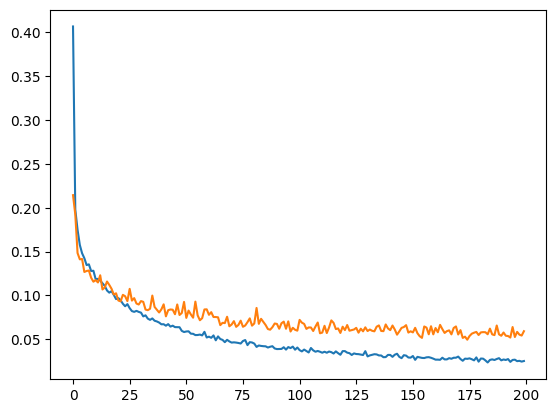

In [20]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [21]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_allowable_velocity.inverse_transform((predictions_scaled))

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
                0
0      899.170227
1      365.966064
2      375.469879
3      283.618591
4      432.042206
...           ...
2403   572.903992
2404   379.827759
2405   739.036499
2406   292.750122
2407  1784.446167

[2408 rows x 1 columns]


In [23]:
y_test["allowable_velocity"]

2273      937.818883
2753      343.812924
6348      324.492157
8023      300.751256
2004      361.314629
            ...     
6450      522.825428
2783      332.999331
1290      479.895193
10716     254.805277
4130     1929.937891
Name: allowable_velocity, Length: 2408, dtype: float64

In [24]:
true= y_test["allowable_velocity"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

86609.03598122715

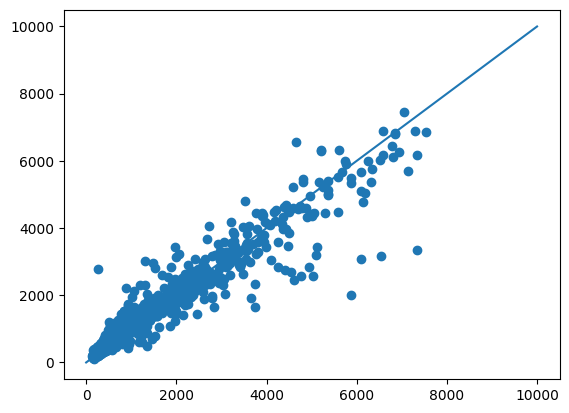

In [25]:
pred=predictions_df
ansys=y_test["allowable_velocity"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 10000],[0, 10000])
plt.show()

In [26]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  2.2 MiB
                             x:  1.7 MiB
                       x_train:  1.4 MiB
           x_train_transformed:  1.0 MiB
                             y: 564.3 KiB
                       y_train: 451.4 KiB
                        x_test: 349.4 KiB
            x_test_transformed: 263.5 KiB
                        y_test: 112.9 KiB
y_train_transformed_allowable_velocity: 75.4 KiB


In [27]:
clear_session()
del model
gc.collect()

0